# Predictive maintenance for turbofan engine example

## Part 2: Linear Regression


Based on open dataset provided by NASA at:
https://data.nasa.gov/widgets/vrks-gjie

dataset can be downloaded at: http://ti.arc.nasa.gov/c/6/

In [1]:
import os
import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

# Load the TensorBoard notebook extension (optional, can be started from the command line)
#%load_ext tensorboard

# Select a plotting style
#plt.style.use('dark_background')
plt.style.use('seaborn')
#plt.style.available

SCALE = 1
SEED = 1
EPOCHS = 20

### Data Preparation

In [2]:
# Load the data

data_root = 'data/'
original_dir = data_root + 'original/'
dataset_dir = data_root + 'dataset/'

train_data = pd.read_csv(dataset_dir + 'train_data.csv')
test_data = pd.read_csv(dataset_dir + 'test_data.csv')
train_data

,Unit,Cycle,OpSet1,OpSet2,OpSet3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


### Quick EDA

Text(0, 0.5, 'RUL')

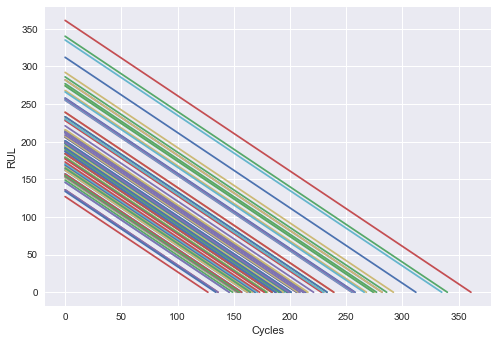

In [3]:
# Plot the lifecycles
one_engine = []
for i, r in train_data.iterrows():
    rul = r['RUL']
    one_engine.append(rul)
    if rul == 0:
        plt.plot(one_engine)
        one_engine = []
        
#plt.grid()
plt.xlabel('Cycles')
plt.ylabel('RUL')

## Machine Learning Application

We will split the data in 4 parts: x_train, y_train, x_test, y_test.

(actually the dataset is already split)
- x is for the sensor data
- y is for the known Remaining Useful Life
- train is for data we will use to train the model (we will use the known RUL in the training)
- test is for data validation... we will apply predictions and compute models performance metrics using the known RUL

In [4]:
# Shuffle train data frame and apply scaling factor
train_data = train_data.sample(frac=SCALE, random_state=SEED).reset_index(drop=True)


# prepare a x frame with useful data and a y frame with RUL value
x_train = train_data.drop(columns=['Unit', 'Cycle', 'RUL'])
y_train = train_data['RUL']

x_test = test_data.drop(columns=['Cycle', 'RUL'])

y_test = test_data['RUL']

In [5]:
# data normalization

mean = x_train.mean()
std = x_train.std()

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std


x_train = x_train.dropna(axis=1, how='any')
x_test = x_test.dropna(axis=1, how='any')

#x_test = np.asarray(x_test).astype('float32')


# what's the shape now we dropped some columns? create a variable to use in 
# get_model_v1 function call
(lines,shape) = x_train.shape

In [6]:
# Build a ML model

def get_model_v1(shape):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='input_layer'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n1'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n2'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n3'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n4'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n5'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n6'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n7'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n8'))
    model.add(keras.layers.Dense(128, activation='relu', name='dense_n9'))
    model.add(keras.layers.Dense(1, name='output'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'],
                 )

    return model

# Instanciate the model

model = get_model_v1((shape,))
model.summary()

2021-12-16 17:41:35.163531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_n1 (Dense)            (None, 128)               2560      
                                                                 
 dense_n2 (Dense)            (None, 128)               16512     
                                                                 
 dense_n3 (Dense)            (None, 128)               16512     
                                                                 
 dense_n4 (Dense)            (None, 128)               16512     
                                                                 
 dense_n5 (Dense)            (None, 128)               16512     
                                                                 
 dense_n6 (Dense)            (None, 128)               16512     
                                                                 
 dense_n7 (Dense)            (None, 128)               1

In [7]:
# Train the model

# Configure callback for vizualization of the training data in tensorboard
if not os.path.exists('logs/'):
    os.mkdir('logs')

log_dir = 'logs/fit/' + f'S{SCALE}_E{EPOCHS}_' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#%tensorboard --logdir ./logs

history = model.fit(x_train,
                    y_train,
                    epochs          = EPOCHS,
                    batch_size      = 20,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks = [tensorboard_callback],)


Epoch 1/20
1032/1032 [==============================] - 4s 3ms/step - loss: 2166.9575 - mae: 32.6036 - mse: 2166.9575 - val_loss: 2381.3938 - val_mae: 40.0155 - val_mse: 2381.3938
Epoch 2/20
1032/1032 [==============================] - 3s 3ms/step - loss: 1812.9679 - mae: 30.0820 - mse: 1812.9679 - val_loss: 2211.2222 - val_mae: 37.8079 - val_mse: 2211.2222
Epoch 3/20
1032/1032 [==============================] - 3s 3ms/step - loss: 1791.4644 - mae: 29.7959 - mse: 1791.4644 - val_loss: 1578.5543 - val_mae: 30.7153 - val_mse: 1578.5543
Epoch 4/20
1032/1032 [==============================] - 3s 3ms/step - loss: 1739.5354 - mae: 29.3916 - mse: 1739.5354 - val_loss: 1566.4302 - val_mae: 30.9002 - val_mse: 1566.4302
Epoch 5/20
1032/1032 [==============================] - 3s 3ms/step - loss: 1762.7805 - mae: 29.4948 - mse: 1762.7805 - val_loss: 1292.9415 - val_mae: 26.9074 - val_mse: 1292.9415
Epoch 6/20
1032/1032 [==============================] - 3s 3ms/step - loss: 1724.5078 - mae: 29.2052

In [8]:
# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=1)

4/4 [==============================] - 0s 5ms/step - loss: 1560.3936 - mae: 28.7302 - mse: 1560.3936


## Training History

In [9]:
df = pd.DataFrame(data=history.history)
display(df)

,loss,mae,mse,val_loss,val_mae,val_mse
0,2166.957520,32.603638,2166.957520,2381.393799,40.015503,2381.393799
1,1812.967896,30.081955,1812.967896,2211.222168,37.807873,2211.222168
2,1791.464355,29.795948,1791.464355,1578.554321,30.715317,1578.554321
3,1739.535400,29.391634,1739.535400,1566.430176,30.900223,1566.430176
4,1762.780518,29.494816,1762.780518,1292.941528,26.907360,1292.941528
5,1724.507812,29.205162,1724.507812,1075.539795,24.552620,1075.539795
6,1729.932861,29.215399,1729.932861,981.315613,23.752247,981.315674
7,1715.180298,29.074425,1715.180298,971.175964,23.295567,971.175964
8,1694.960571,28.943783,1694.960571,865.122131,21.965862,865.122131
9,1689.703125,28.880722,1689.703125,899.492432,23.031607,899.492432


In [10]:
print("min(val_mae) : {:.4f}".format(min(history.history['val_mae'])))

min(val_mae) : 21.9659


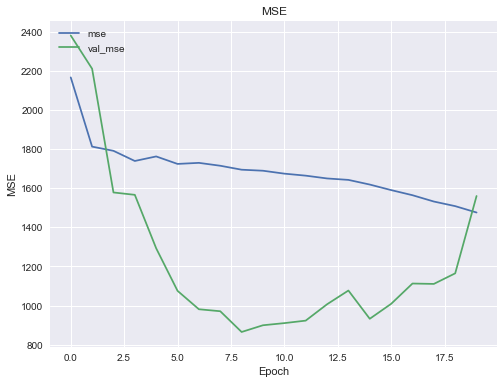

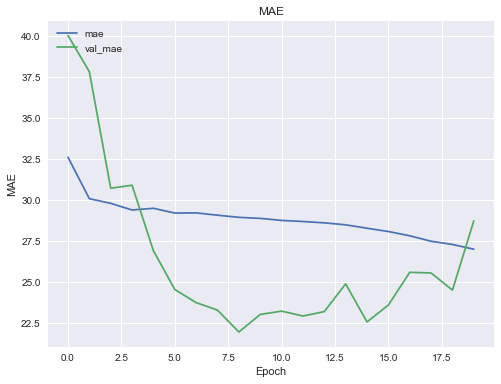

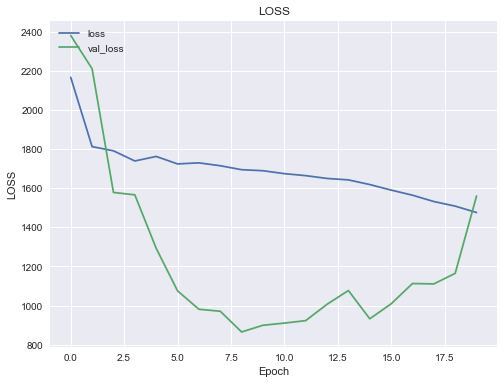

In [11]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        plt.show()


plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                            'MAE' :['mae', 'val_mae'],
                            'LOSS':['loss','val_loss']}, save_as='01-history')

## Make a prediction

In [12]:
# Make a prediction

selection = 56

engine = x_test.iloc[selection]
engine_rul = y_test.iat[selection]
print('Data (denormalized):\n\n', engine.dropna(axis=0, how='any')  * std + mean, '\n\n')
print('RUL = ', engine_rul)

engine = np.array(engine).reshape(1, shape)

print('\n\n---\n\n')

predictions = model.predict(engine)
print('Prediction  : {:.0f} Cycles'.format(predictions[0][0]))
print('Real RUL    : {:.0f} Cycles'.format(engine_rul))

Data (denormalized):

 BleedEnthalpy           394.0000
BurnerFuelAirRatio        0.0300
BypassDuctPres           21.6100
BypassRatio               8.4603
CorrCoreSpeed          8131.7600
CorrFanSpeed           2388.1900
DemandCorrFanSpeed           NaN
DemandFanSpeed               NaN
EnginePresRatio              NaN
FanInletPres             14.6200
FanInletTemp                 NaN
FuelFlowRatio           521.6100
HPCOutletTemp          1590.3800
HPTCoolantBleed          38.7700
LPCOutletTemp           642.1700
LPTCoolantBleed          23.2910
LPTOutletTemp          1411.9500
OpSet1                    0.0035
OpSet2                   -0.0001
OpSet3                       NaN
PhysCoreSpeed          9043.8000
PhysFanSpeed           2388.1100
StaticHPCOutletPres      47.5900
TotalHPCOutletPres      552.4300
dtype: float64 


RUL =  103


---


Prediction  : 84 Cycles
Real RUL    : 103 Cycles


In [13]:
# TODO confusion matrix
predictions = []

for i in range(len(x_test)):
    engine = x_test.iloc[i]
    engine = np.array(engine).reshape(1, shape)
    prediction = model.predict(engine)
    predictions.append(prediction[0][0])

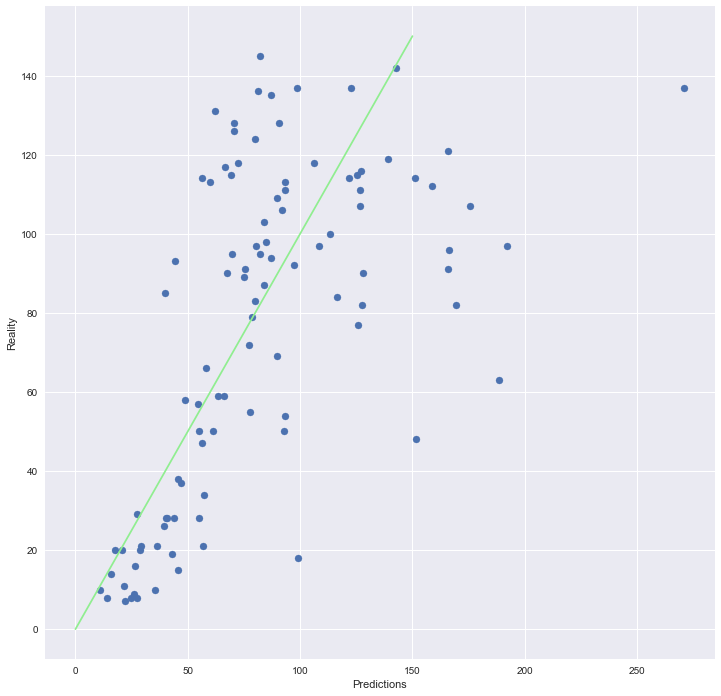

In [14]:
plt.figure(figsize=(12,12))
plt.scatter(predictions, y_test);

# Add a line
x = [0, 150]
y = x
plt.plot(x,y, color='lightgreen');

# Layout
plt.xlabel('Predictions');
plt.ylabel('Reality');

In [15]:
# TODO archive the model for reuse